In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time
import math
import netCDF4 as nc

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import r2_score

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

from pysolar.solar import *
import pytz
import shap
import pickle
import multiprocessing

RANDOM_STATE = 42
n_jobs = multiprocessing.cpu_count()

#  32.5,  33.5
# -97.5, -96.5
RANDOM_STATE = 42
n_jobs = multiprocessing.cpu_count()

In [2]:
folder = "spatial"
node_id = "10004098"
dir_out = "../figures/" + folder + "/"
dir_data = "../data/"

fn_in = dir_data + "driving_" + node_id + "_NEXRAD.csv"


In [3]:
df_all = pd.read_csv(fn_in, parse_dates=True, index_col = 'UTC')

In [4]:
# df_all[(df_all.index.date == datetime.date(2020,4,15)) & (df_all.index.hour == 15) & (df_all.index.minute == 43) ]['spectrum_width 0km']

In [5]:
# drop a few rows with NaN values, NEXRAD file on "20200415_154344" has less keys, no 'velocity' and 'spectrum_width'
df = df_all.dropna()
# refill the -inf values
df = df.replace(-np.Inf, -9999.0)

In [6]:
# Illuminance, 421 bins(360nm-780nm), lat,long,alt, features
features = df.columns[1+421+3:]
targets = df.columns[1:421+1] # 421 bins(360nm-780nm)
target = 'whole'

In [9]:
X = df[features]
# X.rename(columns={'surface reflectance band 1': 'surface reflectance (435-451 nm)',\
#                   'surface reflectance band 2': 'surface reflectance (452-512 nm)',\
#                   'surface reflectance band 3': 'surface reflectance (533-590 nm)',\
#                   'surface reflectance band 4': 'surface reflectance (636-673 nm)'}, inplace = True)
Y = df[targets]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0) 

features = X.columns
targets = Y.columns

In [10]:
n_components = 10 #len(features)

DR = 'PCA'
pca = PCA(n_components=n_components, random_state = RANDOM_STATE)

X_train_DR = pca.fit_transform(X_train)
X_test_DR = pca.transform(X_test)

X_train_DR = pd.DataFrame(X_train_DR)
X_test_DR = pd.DataFrame(X_test_DR)
print(pca.explained_variance_/np.sum(pca.explained_variance_))


[9.99999998e-01 1.61585555e-09 2.18325409e-10 1.08612471e-10
 9.61501433e-11 7.45790753e-11 6.95223692e-11 6.78769536e-11
 6.31079006e-11 5.47673440e-11]


In [16]:
X_train_DR.iloc[:2,:2]

,0,1
0,-4.752359e+07,58370.743204
1,-7.341593e+07,44040.904909


In [30]:
X_train.iloc[:2,:2]

,Zenith,Azimuth
UTC,,
2020-02-11 18:36:10,47.256794,177.807072
2020-02-10 19:47:40,49.916743,201.157907


In [27]:
X_train_DR.shape

(17145, 10)

In [29]:
temp = np.matmul(X_train_DR, pca.components_)

In [31]:
temp.iloc[:2,:2]

,0,1
0,3.886357,-22.031658
1,-3.632358,-6.804278


In [44]:
set(df.index.date)

{datetime.date(2020, 1, 8),
 datetime.date(2020, 1, 9),
 datetime.date(2020, 1, 23),
 datetime.date(2020, 1, 24),
 datetime.date(2020, 1, 27),
 datetime.date(2020, 1, 29),
 datetime.date(2020, 1, 30),
 datetime.date(2020, 1, 31),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 7),
 datetime.date(2020, 2, 10),
 datetime.date(2020, 2, 11),
 datetime.date(2020, 2, 14),
 datetime.date(2020, 2, 21),
 datetime.date(2020, 4, 15),
 datetime.date(2020, 4, 20)}

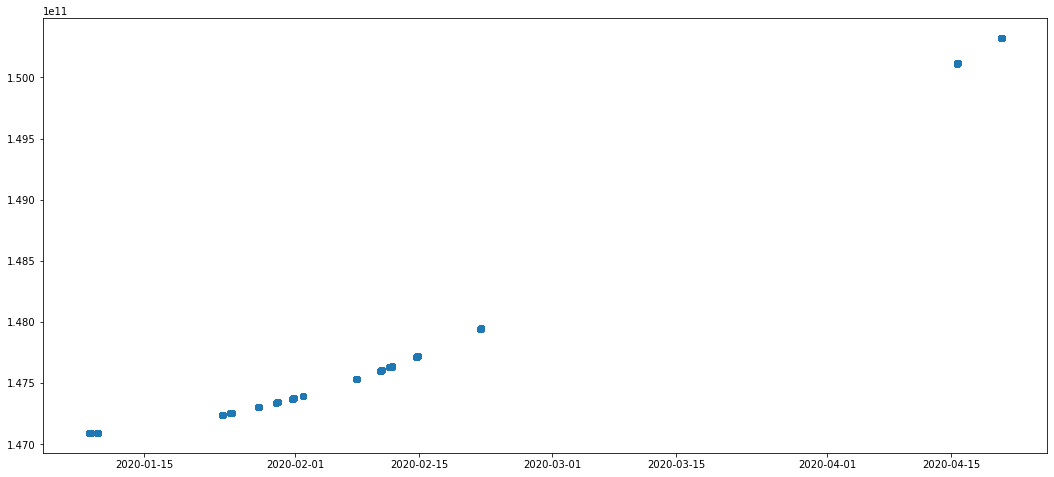

In [47]:
plt.rcParams["figure.figsize"] = (18, 8) # (w, h)
plt.scatter(df.index, df['Sun Distance'])

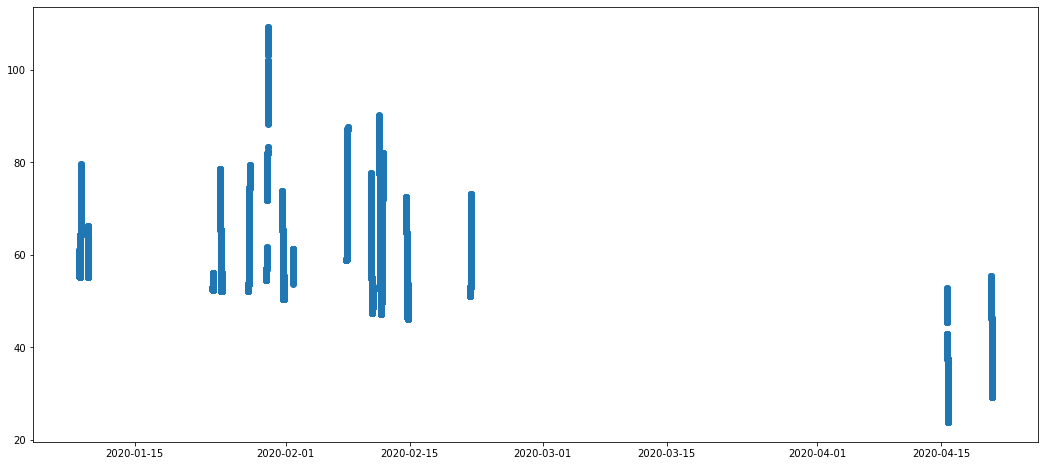

In [49]:
plt.rcParams["figure.figsize"] = (18, 8) # (w, h)
plt.scatter(df.index, df['Zenith'])

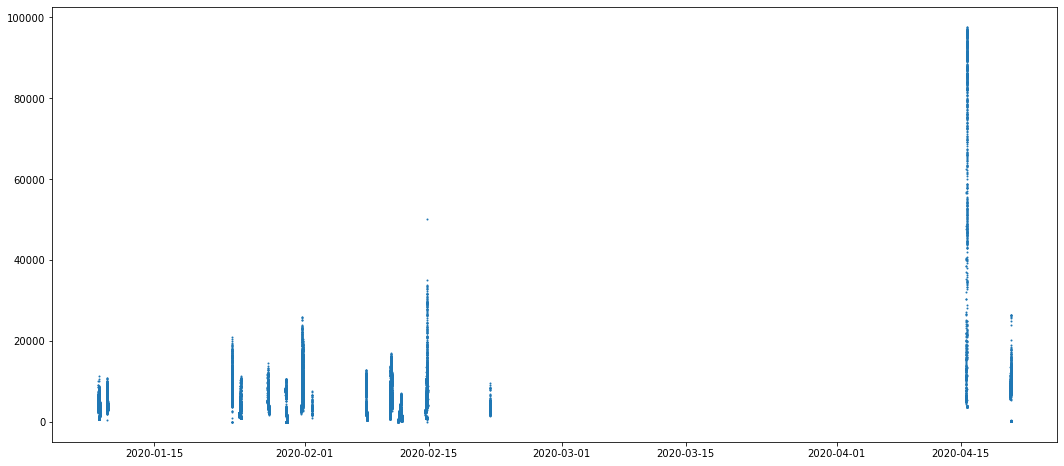

In [51]:
plt.rcParams["figure.figsize"] = (18, 8) # (w, h)
plt.scatter(df.index, df['Illuminance'], s = 1)

In [8]:
max_depth = 50 #CV_rfr.best_params_['max_depth'], # 30
n_estimators = 80 #CV_rfr.best_params_['n_estimators'])#100
min_samples_split = 6
min_samples_leaf = 3
max_samples = None
max_features = None#0.9

start_time = time.time()

regr = RandomForestRegressor(random_state = RANDOM_STATE,
                             max_depth = max_depth,
                             n_estimators = n_estimators,
                             min_samples_split = min_samples_split,
                             min_samples_leaf = min_samples_leaf,
                             max_samples = max_samples,
                             max_features = max_features,
                             n_jobs = n_jobs)
regr.fit(X_train_DR, Y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 54.18612575531006 seconds ---


In [9]:
structure =  '_dep' + str(max_depth) \
            +'_ne' + str(n_estimators) \
            +'_splt' + str(min_samples_split) \
            +'_lf' + str(min_samples_leaf)\
            +'_sr' + str(max_samples)\
            +'_fr' + str(max_features)
fn_model = '../models/spatial_RF_' + target + structure +'.sav'
pickle.dump(regr, open(fn_model, 'wb'))


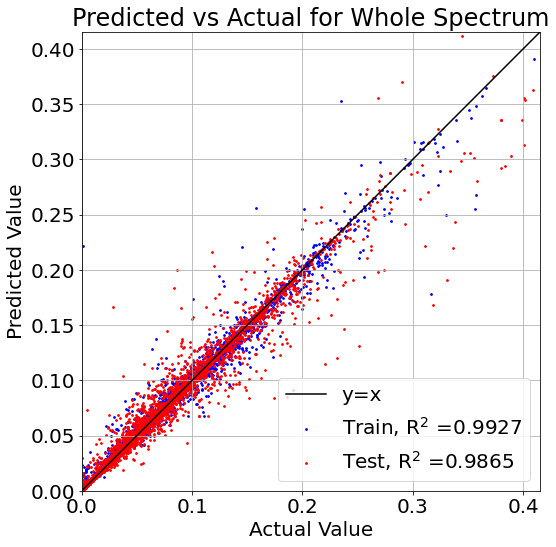

In [14]:
from sklearn.metrics import r2_score
Y_train_pred = regr.predict(X_train_DR)
train_score = r2_score(Y_train, Y_train_pred)

Y_test_pred = regr.predict(X_test_DR)
test_score = r2_score(Y_test, Y_test_pred)

# flatten
Y_train_flatten = Y_train.values.flatten()
Y_train_pred_flatten = Y_train_pred.flatten()

Y_test_flatten = Y_test.values.flatten()
Y_test_pred_flatten = Y_test_pred.flatten()

Y_min = np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 2*np.std(Y_train_flatten)

y_line = np.linspace(Y_min,Y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')

id_train = np.random.choice(len(Y_train_flatten), 5000, replace = False)
plt.scatter(Y_train_flatten[id_train],Y_train_pred_flatten[id_train], s=3, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
id_test = np.random.choice(len(Y_test_flatten), 5000, replace = False)
plt.scatter(Y_test_flatten[id_test],Y_test_pred_flatten[id_test], s=3, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim(Y_min, Y_max)
plt.ylim(Y_min, Y_max)

ax.set_title('Predicted vs Actual for Whole Spectrum')
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()

if not os.path.exists(dir_out + target):
    os.mkdir(dir_out + target)
plt.savefig(dir_out + target +'/spatial_RF_performance_'+target+structure+'.png')


In [15]:
train_scores = []
test_scores = []
for i in range(len(targets)):
    train_scores.append( r2_score(Y_train.iloc[:,i], Y_train_pred[:,i]) )
    test_scores.append( r2_score(Y_test.iloc[:,i], Y_test_pred[:,i]) )


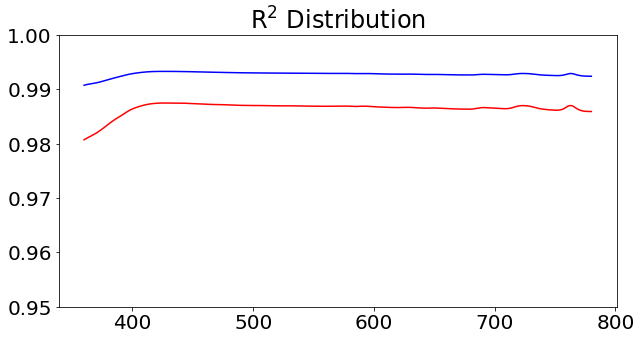

In [17]:
plt.rcParams["figure.figsize"] = (10, 5) # (w, h)
plt.plot(np.array(range(360,780+1)),train_scores, 'b', label = 'Train')
plt.plot(np.array(range(360,780+1)),test_scores, 'r', label = 'Test')
plt.ylim(0.95,1)
plt.title("R$^2$ Distribution")
plt.savefig(dir_out + 'whole' + '/spatial_RF_R2+'+target+structure+'.png')

In [ ]:
# Create object that can calculate shap values
start_time = time.time()

num_shap = 200
# X_sample = shap.sample(X_train_DR, num_shap)
index_sample = np.random.choice(X_train_DR.index, size=num_shap, replace=False)
X_sample = X_train.iloc[index_sample,:]
X_sample_DR = X_train_DR.iloc[index_sample,:]

explainer = shap.TreeExplainer(regr)
# Calculate shap_values
shap_values_DR_multi = explainer.shap_values(X_sample_DR)
shap_values_DR = np.mean(shap_values_DR_multi, axis = 0)

print("--- %s seconds ---" % (time.time() - start_time))

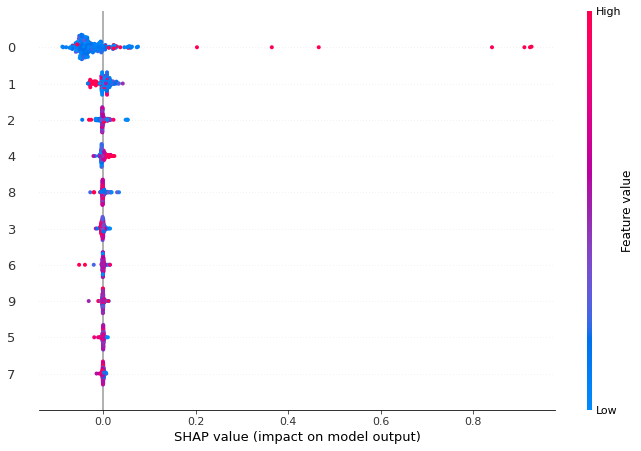

In [44]:
# plot
max_display = 20
shap.summary_plot(shap_values_DR, X_sample,
                  plot_size=(10,max_display/3),#'auto'
                  max_display = max_display,
                  show=False
                 )
plt.tight_layout()
plt.savefig(dir_out + target + '/spatial_RF_shap'+DR+'_'+ target+structure +'.png')

In [60]:
features

Index(['Zenith', 'Azimuth', 'Sun Distance', 'cross_correlation_ratio 0km SW',
       'cross_correlation_ratio 0km S', 'cross_correlation_ratio 0km SE',
       'cross_correlation_ratio 0km W', 'cross_correlation_ratio 0km',
       'cross_correlation_ratio 0km E', 'cross_correlation_ratio 0km NW',
       ...
       'ROI 9km NE', 'ROI 10km SW', 'ROI 10km S', 'ROI 10km SE', 'ROI 10km W',
       'ROI 10km', 'ROI 10km E', 'ROI 10km NW', 'ROI 10km N', 'ROI 10km NE'],
      dtype='object', length=696)

In [58]:
pca.components_[0,:]

array([-7.60756658e-09, -2.09554280e-08,  1.00000000e+00,  1.58602795e-11,
        3.35783055e-11,  2.69776013e-11,  8.16605566e-12,  3.15642474e-11,
        3.99672431e-11,  9.55153961e-12,  4.82831294e-11,  4.72036978e-11,
       -9.02736941e-13,  2.90429160e-11,  2.19153572e-11, -7.99804081e-12,
        1.70866830e-11,  4.32054110e-11,  7.70341599e-12,  4.46986822e-11,
        4.64314216e-11,  1.49268152e-12,  2.80418646e-11,  5.67514935e-12,
       -6.36379787e-12,  2.38740077e-11,  2.84655284e-11, -1.82610254e-12,
        3.08552676e-11,  3.17572670e-11, -3.53296547e-11, -3.50609833e-11,
       -4.17972358e-11, -4.33741463e-11, -4.58248887e-11, -2.80873015e-11,
       -3.67045399e-11, -1.55498321e-11, -1.01604468e-11, -3.35770737e-11,
       -4.05671424e-11, -4.04682391e-11, -3.22271376e-11, -3.86543434e-11,
       -3.64337026e-11, -3.06289733e-11, -2.82191023e-11, -3.56488562e-11,
       -3.63781893e-11, -3.48488152e-11, -3.45908387e-11, -3.16267033e-11,
       -3.15477379e-11, -

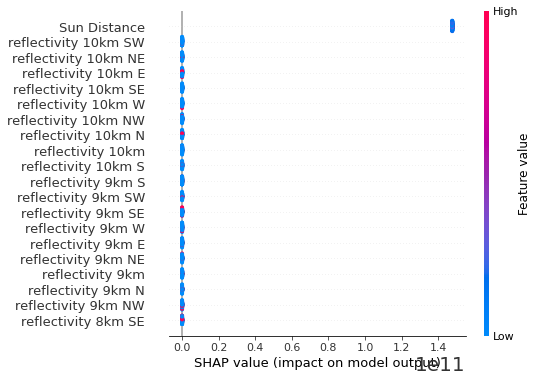

In [52]:
# plot
max_display = 20 #num_features
shap_values = pca.inverse_transform(shap_values_DR)
shap.summary_plot(shap_values, X_sample,
                  feature_names = features,
                  plot_size=(8,max_display/3.5),#'auto'
                  max_display = max_display,
                  show=False
                 )
plt.tight_layout()
plt.savefig(dir_out + 'whole' + '/MLP_shap_'+ target + structure+'.png')

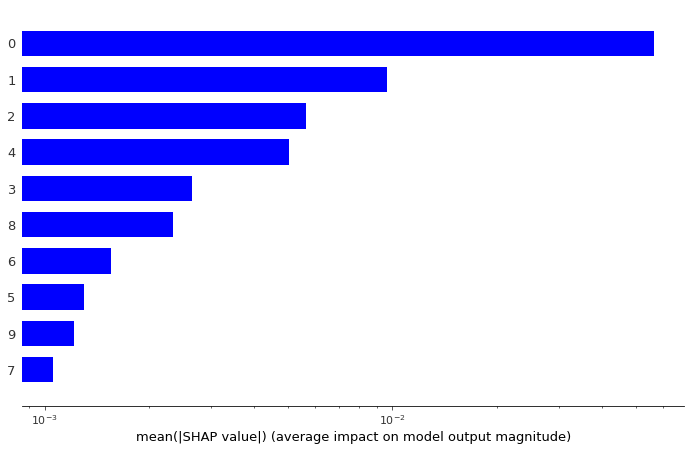

In [23]:
shap.summary_plot(np.mean(shap_values, axis = 0), X_sample,
                  plot_size=(10,max_display/3),#'auto'
                  color = 'blue',
                  max_display = max_display,
                  show=False,
                  plot_type = 'bar'
                 )
plt.xscale("log")
ax.set_title('Feature Importances for Street-Level Spectral Irradiance')
plt.tight_layout()
plt.savefig(dir_out + target + '/spatial_RF_Importances'+DR+'_'+target+structure+'.png')

## Compare Full Spectrum with Prediction


In [97]:
from wavelength_to_rgb import wavelength_to_rgb
clim=(350,780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
colorlist = list(zip(norm(wl),[wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)


In [269]:
jetlag = 6

year = 2020
month = 2
day = 10
hour = 13+jetlag
minute = 0
second = 0
date_string = '%04d-%02d-%02d %02d:%02d:%02d' % (year, month, day, hour, minute, second)
iwant = (X.index == date_string)


wavelengths = np.array(range(360,780+1))

x1 = X[iwant].index.values
y1 = Y[iwant].values
y1_pred = regr.predict(X[iwant])

date_string

'2020-02-10 19:00:00'

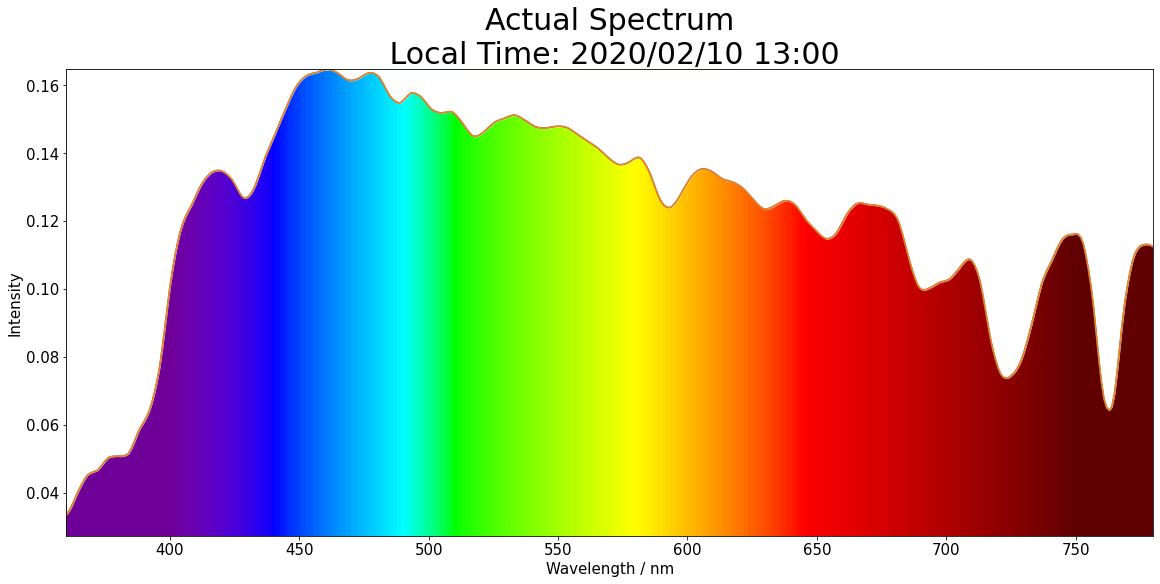

In [270]:
y_plot_min = np.min([np.min(y1), np.min(y1_pred)])
y_plot_max = np.max([np.max(y1), np.max(y1_pred)])


fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})

spectrum = y1.flatten()
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y2 = np.linspace(0, y_plot_max, 100)

XX,YY = np.meshgrid(wavelengths, y2)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), y_plot_min, y_plot_max)

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, y_plot_max, color='w')
ax.set_title('Actual Spectrum\n Local Time: %02d/%02d/%02d %02d:%02d' % (year, month, day, hour-jetlag, minute))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Intensity')

fig.savefig(dir_out+'Spectrum_%02d_%02d_%02d_%02d_%02d.png' % (year, month, day, hour-jetlag, minute))
#plt.close()

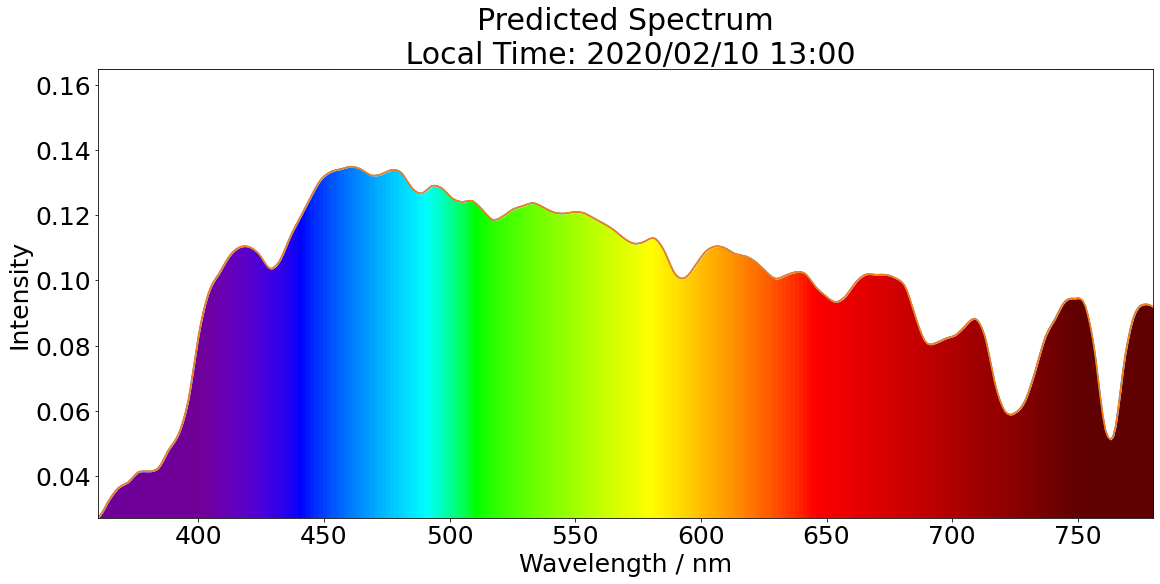

In [271]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})
spectrum = y1_pred.flatten()
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y2 = np.linspace(0, np.max(spectrum)*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y2)
XX[XX<400] = 400
# extent=(np.min(wavelengths), np.max(wavelengths), np.min(y2), np.max(y2))
# y_upper = np.max(spectrum)*1.1

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, y_plot_max, color='w')
ax.set_title('Predicted Spectrum\n Local Time: %02d/%02d/%02d %02d:%02d' % (year, month, day, hour-jetlag, minute))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Intensity')

fig.savefig(dir_out+'Spectrum_%02d_%02d_%02d_%02d_%02d_pred.png' % (year, month, day, hour-jetlag, minute))
#plt.close()